In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [ ]:
DATA_PATH = 'drive/MyDrive/march_madness/2024/march-machine-learning-mania-2024/'

### Read in tournament seeds

In [ ]:
tmp1 = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
tmp2 = pd.read_csv(DATA_PATH + 'WNCAATourneySeeds.csv')
tmp2 = tmp2[tmp2.Season >= 2010] # women's data needs to start at 2010 because that is when we have advanced metrics available
df_seeds = pd.concat((tmp1, tmp2))

df_seeds = df_seeds[df_seeds.Season >= 2003]
df_seeds = df_seeds[df_seeds.Season < 2024]

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['SeedNumeric'] = df_seeds['Seed'].apply(treat_seed)

print(df_seeds.shape)
df_seeds.head()

(2176, 4)


,Season,Seed,TeamID,SeedNumeric
1154,2003,W01,1328,1
1155,2003,W02,1448,2
1156,2003,W03,1393,3
1157,2003,W04,1257,4
1158,2003,W05,1280,5


### Read in season results and create NumWins, NumLosses

In [ ]:
tmp1 = pd.read_csv(DATA_PATH + 'MRegularSeasonCompactResults.csv')
tmp2 = pd.read_csv(DATA_PATH + 'WRegularSeasonCompactResults.csv')
tmp2 = tmp2[tmp2.Season >= 2010]
df_season_results = pd.concat((tmp1, tmp2))

df_season_results = df_season_results[df_season_results.Season >= 2003]
df_season_results = df_season_results[df_season_results.Season < 2024]

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

print(df_season_results.shape)
df_season_results.head()

(178706, 6)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore
74048,2003,10,1104,68,1328,62
74049,2003,10,1272,70,1393,63
74050,2003,11,1266,73,1437,61
74051,2003,11,1296,56,1457,50
74052,2003,11,1400,77,1208,71


In [ ]:
# number of wins
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

# number of losses
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

print(num_loss.shape)
num_loss.head()

(12123, 3)


,Season,TeamID,NumLosses
0,2003,1102,16
1,2003,1103,14
2,2003,1104,11
3,2003,1105,19
4,2003,1106,15


In [ ]:
# number of wins over last 14 days
num_win_last14 = df_season_results[df_season_results.DayNum >= 132-14].groupby(['Season', 'WTeamID']).count()
num_win_last14 = num_win_last14.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins14", "WTeamID": "TeamID"})

# number of losses over last 14 days
num_loss_last14 = df_season_results[df_season_results.DayNum >= 132-14].groupby(['Season', 'LTeamID']).count()
num_loss_last14 = num_loss_last14.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses14", "LTeamID": "TeamID"})

# create one dataframe with the ratio over last 14 days
win_ratio_last14 = num_win_last14.merge(num_loss_last14,
                                       left_on=['Season','TeamID'],
                                       right_on=['Season','TeamID'],
                                       how='outer').fillna(0)

win_ratio_last14['WinRatio14'] = win_ratio_last14['NumWins14'] / (win_ratio_last14['NumWins14'] + win_ratio_last14['NumLosses14'])
win_ratio_last14.drop(columns=['NumWins14', 'NumLosses14'], inplace=True)
print(win_ratio_last14.shape)
win_ratio_last14

(11756, 3)


,Season,TeamID,WinRatio14
0,2003,1102,0.333333
1,2003,1103,0.333333
2,2003,1104,0.500000
3,2003,1106,0.500000
4,2003,1108,0.400000
...,...,...,...
11751,2023,3462,0.000000
11752,2023,3464,0.000000
11753,2023,3468,0.000000
11754,2023,3474,0.000000


### Read in detailed season results and create some advanced metrics

(from https://en.wikipedia.org/wiki/Advanced_statistics_in_basketball)

Possessions = 0.96 * (FGA - ORb + TO + (0.475 * FTA))

Offensive Efficiency (OffEff) = PointsScored * 100 / Possessions

Defensive Efficiency (DefEff) = PointsAllowed * 100 / Possessions

Effective Technical Shooting Percentage (EFT) = (FGM + 0.5 * FGM3) / FGA

In [ ]:
tmp1 = pd.read_csv(DATA_PATH + 'MRegularSeasonDetailedResults.csv')
tmp2 = pd.read_csv(DATA_PATH + 'WRegularSeasonDetailedResults.csv')
df_season_stats = pd.concat((tmp1, tmp2))

df_season_stats = df_season_stats[df_season_stats.Season >= 2003]
df_season_stats = df_season_stats[df_season_stats.Season < 2024]
df_season_stats.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

# advanced metrics for winning teams
df_season_stats['WPoss'] = 0.96 * (df_season_stats['WFGA'] - df_season_stats['WOR']
                                   + df_season_stats['WTO'] + (0.475 * df_season_stats['WFTA']))
df_season_stats['WOffEff'] = df_season_stats['WScore'] / df_season_stats['WPoss'] * 100
df_season_stats['WDefEff'] = df_season_stats['LScore'] / df_season_stats['WPoss'] * 100
df_season_stats['WEFT'] = (df_season_stats['WFGM'] + 0.5 * df_season_stats['WFGM3']) / df_season_stats['WFGA']

# advanced metrics for losing teams
df_season_stats['LPoss'] = 0.96 * (df_season_stats['LFGA'] - df_season_stats['LOR']
                                   + df_season_stats['LTO'] + (0.475 * df_season_stats['LFTA']))
df_season_stats['LOffEff'] = df_season_stats['LScore'] / df_season_stats['LPoss'] * 100
df_season_stats['LDefEff'] = df_season_stats['WScore'] / df_season_stats['LPoss'] * 100
df_season_stats['LEFT'] = (df_season_stats['LFGM'] + 0.5 * df_season_stats['LFGM3']) / df_season_stats['LFGA']

df_season_stats['Weights'] = np.ones(df_season_stats.shape[0])

print(df_season_stats.shape)
print(df_season_stats.columns)
df_season_stats.head()

(178417, 41)
Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WPoss', 'WOffEff',
       'WDefEff', 'WEFT', 'LPoss', 'LOffEff', 'LDefEff', 'LEFT', 'Weights'],
      dtype='object')


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,...,LPF,WPoss,WOffEff,WDefEff,WEFT,LPoss,LOffEff,LDefEff,LEFT,Weights
0,2003,10,1104,68,1328,62,27,58,3,14,...,20,72.528,93.756894,85.484227,0.491379,68.592,90.389550,99.136926,0.433962,1.0
1,2003,10,1272,70,1393,63,26,62,8,20,...,16,66.264,105.638054,95.074248,0.483871,65.760,95.802920,106.447689,0.402985,1.0
2,2003,11,1266,73,1437,61,24,58,8,18,...,23,62.184,117.393542,98.095973,0.482759,62.328,97.869336,117.122321,0.321918,1.0
3,2003,11,1296,56,1457,50,18,38,3,9,...,23,56.376,99.333050,88.690223,0.513158,55.800,89.605735,100.358423,0.428571,1.0
4,2003,11,1400,77,1208,71,30,61,6,14,...,14,61.608,124.983768,115.244773,0.540984,61.272,115.876746,125.669147,0.435484,1.0


In [ ]:
# average advanced metrics for winning teams
win_metrics = df_season_stats.groupby(['Season', 'WTeamID']).mean().reset_index()
win_metrics = win_metrics[['Season', 'WTeamID', 'WOffEff', 'WDefEff', 'WEFT']]

# average advanced metrics for losing teams
loss_metrics = df_season_stats.groupby(['Season', 'LTeamID']).mean().reset_index()
loss_metrics = loss_metrics[['Season', 'LTeamID', 'LOffEff', 'LDefEff', 'LEFT']]

print(win_metrics.shape)
print(loss_metrics.shape)
loss_metrics.head()

(12107, 5)
(12122, 5)


,Season,LTeamID,LOffEff,LDefEff,LEFT
0,2003,1102,94.626537,115.946037,0.503591
1,2003,1103,106.003538,117.710095,0.484527
2,2003,1104,98.552254,114.146788,0.429002
3,2003,1105,93.265321,108.981465,0.446777
4,2003,1106,92.268727,106.691278,0.450522


In [ ]:
# merge the advanced metrics into a single dataframe
adv_metrics = win_metrics.merge(loss_metrics,
                                left_on=['Season','WTeamID'],
                                right_on=['Season','LTeamID'],
                                how='outer').drop('LTeamID', axis=1).rename(columns={'WTeamID':'TeamID'})
adv_metrics.fillna(0, inplace=True)

print(adv_metrics.shape)
adv_metrics.head()

(12135, 8)


,Season,TeamID,WOffEff,WDefEff,WEFT,LOffEff,LDefEff,LEFT
0,2003,1102.0,126.012887,96.797867,0.692162,94.626537,115.946037,0.503591
1,2003,1103.0,125.045756,111.736866,0.592604,106.003538,117.710095,0.484527
2,2003,1104.0,113.581339,93.531458,0.506056,98.552254,114.146788,0.429002
3,2003,1105.0,106.669505,89.356373,0.488400,93.265321,108.981465,0.446777
4,2003,1106.0,103.644271,87.931715,0.517668,92.268727,106.691278,0.450522


### Read in tourney results, round

Advanced metrics same as regular season data

Rounds defined by the DayNum of the games:
* Round 0: 134, 135 (play-ins)
* Round 1: 136, 137 (Round of 64)
* Round 2: 138, 139, 140 (Round of 32)
* Round 3: 143, 144 (Sweet Sixteen)
* Round 4: 145, 146, 147, 148 (Elite Eight)
* Round 5: 152 (Final Four)
* Round 6: 154 (Championship)

Adding weights for the tournament games (so later rounds are more important to get right, corresponds to 2x bracket scoring):
* Regular Season: 1
* Round 0/1: 2
* Round 2: 4
* Round 3: 8
* Round 4: 16
* Round 5: 32
* Round 6: 64

In [ ]:
tmp1 = pd.read_csv(DATA_PATH + 'MNCAATourneyCompactResults.csv')
tmp2 = pd.read_csv(DATA_PATH + 'WNCAATourneyCompactResults.csv')
tmp2 = tmp2[tmp2.Season >= 2010]

df_tourney_results = pd.concat((tmp1, tmp2))
df_tourney_results = df_tourney_results[df_tourney_results.Season >= 2003]
df_tourney_results = df_tourney_results[df_tourney_results.Season < 2024].drop(['WLoc', 'NumOT'], axis=1)

weights = []
bad_days = []
for dn in df_tourney_results.DayNum:
  if dn in [134, 135, 136, 137]:
    weights.append(2)
  elif dn in [138, 139, 140, 141, 142]:
    weights.append(4)
  elif dn in [143, 144]:
    weights.append(8)
  elif dn in [145, 146, 147, 148]:
    weights.append(16)
  elif dn in [151, 152, 153]:
    weights.append(32)
  elif dn in [154, 155]:
    weights.append(64)
  else:
    if dn not in bad_days:
      bad_days.append(dn)

print(bad_days)
df_tourney_results['Weights'] = weights
print(df_tourney_results.shape)
df_tourney_results.head()

[]
(2142, 7)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Weights
1136,2003,134,1421,92,1411,84,2
1137,2003,136,1112,80,1436,51,2
1138,2003,136,1113,84,1272,71,2
1139,2003,136,1141,79,1166,73,2
1140,2003,136,1143,76,1301,74,2


### Merge all the data into a single DataFrame

In [ ]:
# Season, single value data
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_ratio_last14, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(adv_metrics, on=['Season', 'TeamID'], how='left')

df_features_season.fillna(0, inplace=True) # add zeros where teams won or lost 0 games

df_features_season['OffEff'] = ((df_features_season['WOffEff'] * df_features_season['NumWins'] +
                                 df_features_season['LOffEff'] * df_features_season['NumLosses'])
                                / (df_features_season['NumWins'] + df_features_season['NumLosses']))

df_features_season['DefEff'] = ((df_features_season['WDefEff'] * df_features_season['NumWins'] +
                                 df_features_season['LDefEff'] * df_features_season['NumLosses'])
                                / (df_features_season['NumWins'] + df_features_season['NumLosses']))

df_features_season['EFT'] = ((df_features_season['WEFT'] * df_features_season['NumWins'] +
                                 df_features_season['LEFT'] * df_features_season['NumLosses'])
                                / (df_features_season['NumWins'] + df_features_season['NumLosses']))

df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])

df_features_season.drop(['NumWins', 'NumLosses','WOffEff', 'LOffEff', 'WDefEff', 'LDefEff', 'WEFT', 'LEFT'], axis=1, inplace=True)

print(df_features_season.shape)
df_features_season.head()

(12136, 7)


,Season,TeamID,WinRatio14,OffEff,DefEff,EFT,WinRatio
0,2003,1102,0.333333,108.077830,107.739678,0.584407,0.428571
1,2003,1103,0.333333,115.172014,114.834096,0.536564,0.481481
2,2003,1104,0.500000,107.677056,101.630338,0.475785,0.607143
3,2003,1105,0.000000,96.874140,103.697787,0.457983,0.269231
4,2003,1106,0.500000,97.550229,97.981481,0.481697,0.464286


In [ ]:
# remove teams with no wins or 0 efficiency (they are probably bad data points)
df_features_season = df_features_season[df_features_season['WinRatio'] != 0]
df_features_season = df_features_season[df_features_season['OffEff'] != 0]

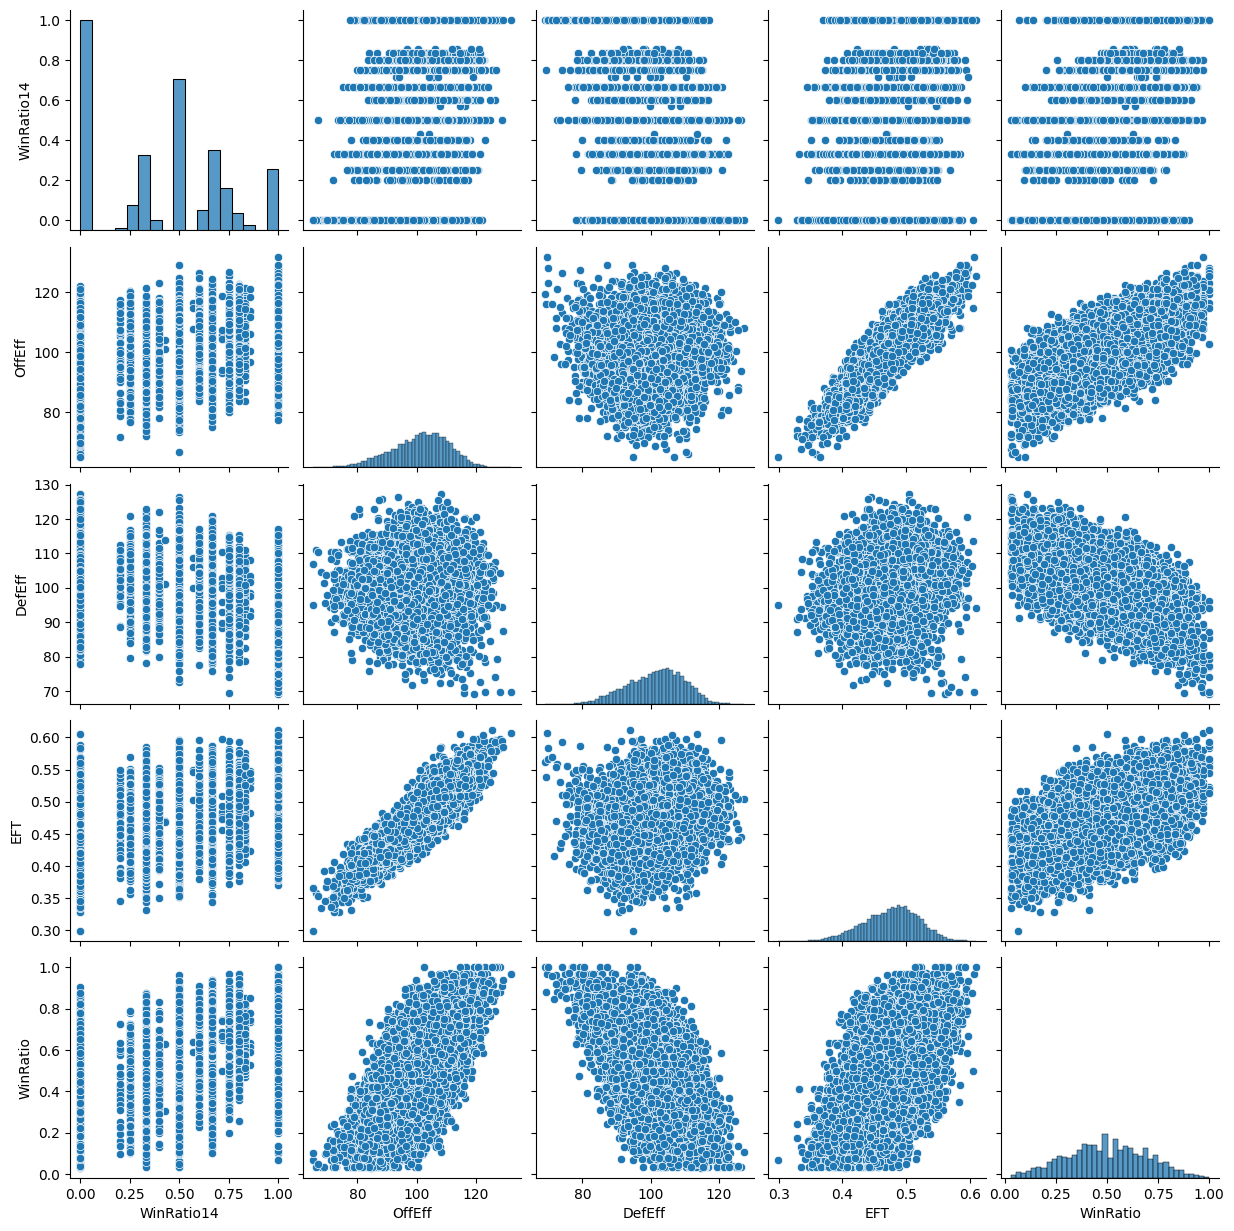

In [ ]:
sns.pairplot(df_features_season.drop(columns=['Season', 'TeamID']))

In [ ]:
# Tournaments and seeds
df_features_tourney = pd.merge(
    df_tourney_results,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop(['TeamID','Seed','DayNum'], axis=1).rename(columns={'SeedNumeric':'SeedW'})

df_features_tourney = pd.merge(
    df_features_tourney,
    df_seeds,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop(['TeamID', 'Seed'], axis=1).rename(columns={'SeedNumeric': 'SeedL'})

print(df_features_tourney.shape)
df_features_tourney.head()

(2142, 8)


,Season,WTeamID,WScore,LTeamID,LScore,Weights,SeedW,SeedL
0,2003,1421,92,1411,84,2,16,16
1,2003,1112,80,1436,51,2,1,16
2,2003,1113,84,1272,71,2,10,7
3,2003,1141,79,1166,73,2,11,6
4,2003,1143,76,1301,74,2,8,9


In [ ]:
# Merge tourney features and season features
df = pd.merge(
    df_features_tourney,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioW',
    'OffEff': 'OffEffW',
    'DefEff': 'DefEffW',
    'EFT': 'EFTW',
    'WinRatio14': 'WinRatio14W',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioL',
    'OffEff': 'OffEffL',
    'DefEff': 'DefEffL',
    'EFT': 'EFTL',
    'WinRatio14': 'WinRatio14L',
}).drop(columns='TeamID', axis=1)

print(df.shape)
print(df.columns)
df.head()

(2142, 18)
Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'Weights', 'SeedW',
       'SeedL', 'WinRatio14W', 'OffEffW', 'DefEffW', 'EFTW', 'WinRatioW',
       'WinRatio14L', 'OffEffL', 'DefEffL', 'EFTL', 'WinRatioL'],
      dtype='object')


,Season,WTeamID,WScore,LTeamID,LScore,Weights,SeedW,SeedL,WinRatio14W,OffEffW,DefEffW,EFTW,WinRatioW,WinRatio14L,OffEffL,DefEffL,EFTL,WinRatioL
0,2003,1421,92,1411,84,2,16,16,1.000000,105.315164,115.456256,0.489800,0.448276,0.833333,107.187241,105.071425,0.503036,0.600000
1,2003,1112,80,1436,51,2,1,16,0.666667,115.232944,95.117513,0.517632,0.892857,1.000000,106.911164,99.247639,0.494732,0.655172
2,2003,1113,84,1272,71,2,10,7,0.500000,113.782349,103.406731,0.517334,0.620690,0.750000,109.889666,97.004974,0.498337,0.793103
3,2003,1141,79,1166,73,2,11,6,1.000000,114.122499,105.421379,0.572835,0.793103,1.000000,118.566346,96.739284,0.567455,0.878788
4,2003,1143,76,1301,74,2,8,9,0.500000,109.611481,102.725168,0.524098,0.724138,0.500000,111.669631,105.001178,0.534189,0.600000


In [ ]:
df.to_csv('drive/MyDrive/march_madness/2024/features_2003-2023.csv', index=False)

In [ ]:
# Add losing matches
def add_losing_matches(df):
    win_rename = {
        "WTeamID": "TeamIDA",
        "WScore" : "ScoreA",
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})

    lose_rename = {
        "WTeamID": "TeamIDB",
        "WScore" : "ScoreB",
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})

    win_df = df.copy()
    lose_df = df.copy()

    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)

    return pd.concat([win_df, lose_df], axis=0, sort=False)


df = add_losing_matches(df)
print(df.shape)
df.head()

(4284, 18)


,Season,TeamIDA,ScoreA,TeamIDB,ScoreB,Weights,SeedA,SeedB,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB
0,2003,1421,92,1411,84,2,16,16,1.000000,105.315164,115.456256,0.489800,0.448276,0.833333,107.187241,105.071425,0.503036,0.600000
1,2003,1112,80,1436,51,2,1,16,0.666667,115.232944,95.117513,0.517632,0.892857,1.000000,106.911164,99.247639,0.494732,0.655172
2,2003,1113,84,1272,71,2,10,7,0.500000,113.782349,103.406731,0.517334,0.620690,0.750000,109.889666,97.004974,0.498337,0.793103
3,2003,1141,79,1166,73,2,11,6,1.000000,114.122499,105.421379,0.572835,0.793103,1.000000,118.566346,96.739284,0.567455,0.878788
4,2003,1143,76,1301,74,2,8,9,0.500000,109.611481,102.725168,0.524098,0.724138,0.500000,111.669631,105.001178,0.534189,0.600000


In [ ]:
# Compute Difference in Final Score (ScoreDiff) and whether or not the team won (WinA)
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)
df.drop(['ScoreA', 'ScoreB'], axis=1, inplace=True)

print(df.shape)
df.head()

(4284, 18)


,Season,TeamIDA,TeamIDB,Weights,SeedA,SeedB,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,ScoreDiff,WinA
0,2003,1421,1411,2,16,16,1.000000,105.315164,115.456256,0.489800,0.448276,0.833333,107.187241,105.071425,0.503036,0.600000,8,1
1,2003,1112,1436,2,1,16,0.666667,115.232944,95.117513,0.517632,0.892857,1.000000,106.911164,99.247639,0.494732,0.655172,29,1
2,2003,1113,1272,2,10,7,0.500000,113.782349,103.406731,0.517334,0.620690,0.750000,109.889666,97.004974,0.498337,0.793103,13,1
3,2003,1141,1166,2,11,6,1.000000,114.122499,105.421379,0.572835,0.793103,1.000000,118.566346,96.739284,0.567455,0.878788,6,1
4,2003,1143,1301,2,8,9,0.500000,109.611481,102.725168,0.524098,0.724138,0.500000,111.669631,105.001178,0.534189,0.600000,2,1


### Save the data to a new csv

In [ ]:
df.to_csv('drive/MyDrive/march_madness/2024/final_data_2003-2023.csv', index=False)